In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

In [2]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

# Pricing Black-Scholes, Call 1d

In [3]:
r = 0.1
sigma = 0.25
x0 = 100.
K = 100.
N, T = 10, 1

## Formule fermée du prix $P$ et du $\delta = \frac{\partial P}{\partial x}$

In [4]:
from scipy.stats import norm

def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [5]:
price_call_BS(x0, T, r, sigma, K)

14.9757907783113

In [6]:
dprice_call_BS(x0, T, r, sigma, K)

0.7002084045313042

# Couverture 

Pour la couverture on considère des dates $t_n = n \frac{T}{N}$, $n=0,\dots,N$ avec $N \in \{10, 100, 1000\}$. 

In [7]:
def simu_S(N, M): 
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = x0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [8]:
N, M = 10, int(1e6)
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

In [9]:
monte_carlo(np.exp(-r*T)*np.maximum(sample[N]-K, 0))

{'mean': 14.952873972698455,
 'var': 395.04696154742516,
 'lower': 14.913918143416758,
 'upper': 14.991829801980153}

In [10]:
P0m = np.exp(-r*T)*np.maximum(sample[N]-K, 0).mean()
print("Prix Monte Carlo:", P0m)

Prix Monte Carlo: 14.95287397269846


In [11]:
P0e = price_call_BS(x0, T, r, sigma, K)
print("Prix exact:", P0e)

Prix exact: 14.9757907783113


In [12]:
value0 = P0e - np.exp(-r*T)*np.maximum(sample[N]-K, 0)
monte_carlo(value0)

{'mean': 0.022916805612845162,
 'var': 395.04696154742516,
 'lower': -0.016039023668852452,
 'upper': 0.061872634894542776}

In [13]:
(value0 > 0).mean()

0.632392

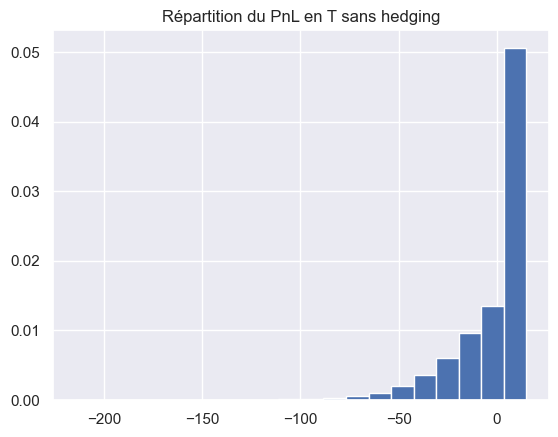

In [14]:
fig, ax = plt.subplots()
ax.hist(value0, bins=20, density=True)
ax.set_title("Répartition du PnL en T sans hedging")
plt.show()

## Avec couverture en delta-hedging

In [16]:
delta = np.zeros_like(sample)
for n in range(N): 
    delta[n] = dprice_call_BS(sample[n], (N-n)*T/N)

In [17]:
value = np.zeros_like(sample)
value[0] = P0e - delta[0] * sample_act[0]   # on peut changer en P0m
for n in range(1,N):
    value[n] = value[n-1] - (delta[n] - delta[n-1]) * sample_act[n]
value[N] = value[N-1] + delta[N-1] * sample_act[N] - np.exp(-r*T)*np.maximum(sample[N]-K, 0)

In [19]:
monte_carlo(value[N])

{'mean': -0.001190100022916837,
 'var': 5.425906584940877,
 'lower': -0.005755556923489164,
 'upper': 0.0033753568776554894}

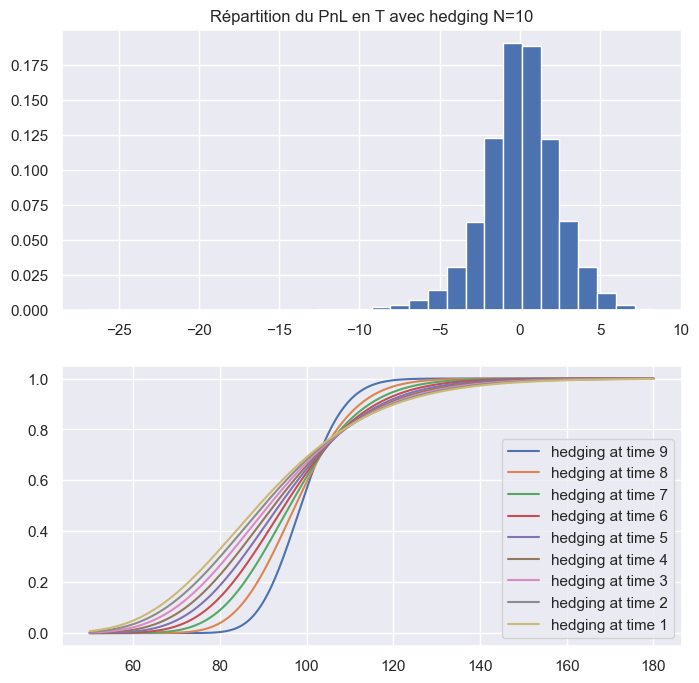

In [20]:
xx = np.linspace(50, 180, 1000)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.hist(value[N], bins=30, density=True)
ax1.set_title(f"Répartition du PnL en T avec hedging N={N}")
for n in reversed(range(1, N)):
    ax2.plot(xx, dprice_call_BS(xx, (N-n)*T/N), label=f"hedging at time {n}")
ax2.legend()
plt.show()

In [22]:
(value[N] > 0).mean()

0.514259

## Couverture comme un problème d'optimisation

### Cas $N=1$

In [23]:
N, M = 1, int(1e6)
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample
Z_tilde = np.exp(-r*T)*np.maximum(sample[N]-K, 0)

In [24]:
# on peut faire soit sur les quantités actualisées soit sur la vision "trader"
def pnl(q0): 
    return np.exp(r*T)*(P0e + q0 * (sample_act[1] - sample_act[0]) - Z_tilde)             # bilan actualisé
    #return (P0e - q0*sample[0])*np.exp(r*T) + (q0*sample[1] - np.maximum(sample[1]-K,0))  # bilan trader

In [25]:
q0s = np.linspace(0.5, 1., 100)
mean_d = np.array([ np.mean(pnl(q0)) for q0 in q0s])
loss_d = np.array([ np.mean(pnl(q0)**2) for q0 in q0s])  # couverture en moyenne quadratique

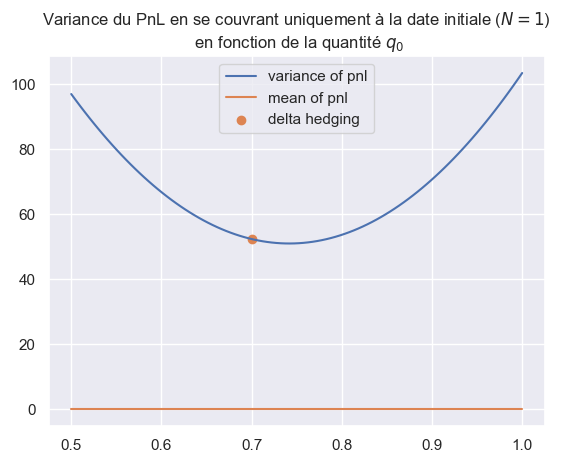

In [26]:
fig, ax = plt.subplots()
ax.plot(q0s, loss_d, label='variance of pnl')
ax.plot(q0s, mean_d, label='mean of pnl')
ax.scatter(delta[0][0], np.mean(pnl(delta[0][0])**2), color='C1', label='delta hedging')
#ax.scatter(0., np.mean(pnl(0.)**2) , color='C2', label='no hedging')
ax.legend()
ax.set_title(f"Variance du PnL en se couvrant uniquement à la date initiale ($N=1$) \n en fonction de la quantité $q_0$")
plt.show()

## Courverture approchée par réseaux de neurones 

In [27]:
import torch 
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [ nn.Linear(input_size, layer_sizes[0]),
                   nn.ReLU() ]
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

## Préparation données, normalisation

In [48]:
N, M = 10, 2**20
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

# on normalise (pour faciliter la descente de gradient) de façon en divisant tout par L = 200 (2*x0) 
L = 2*x0

data_size = M
xj_path = torch.from_numpy(sample_act).to(device).float().T / L
zj = torch.from_numpy(np.exp(-r*T)*np.maximum(sample[N]-K, 0))[:,None].to(device).float() / L

In [49]:
print("plage de valeur des xj_path: ", xj_path.min(), xj_path.max())
print("plage de valeur des zj:      ", zj.min(), zj.max())

plage de valeur des xj_path:  tensor(0.1398) tensor(1.5727)
plage de valeur des zj:       tensor(0.) tensor(1.0537)


In [50]:
# ecriture version math
def pnl_math(xj_path, zj, phi): 
    value = torch.zeros_like(xj_path[:,[0]])
    delta = []
    p0, delta0 = phi(0, xj_path[:,[0]])
    value = p0
    delta.append(delta0)
    for n in range(0, N): 
        value = value + delta[-1] * (xj_path[:, [n+1]] - xj_path[:, [n]]) 
        if n < N-1:
            delta.append(phi(n+1, xj_path[:,[n+1]]))
    value -= zj
    return value * math.exp(r*T)

In [51]:
# ecriture version trader 
def pnl_trader(xj_path, zj, phi): 
    value = torch.zeros_like(xj_path[:,[0]])
    delta = []
    
    p0, delta0 = phi(0, xj_path[:,[0]])
    delta.append(delta0)
    value = p0 - delta0 * xj_path[:,[0]]
    for n in range(1,N):
        delta.append(phi(n, xj_path[:,[n]]))
        value = value - (delta[n] - delta[n-1]) * xj_path[:,[n]]
    value = value + delta[N-1] * xj_path[:,[N]] - zj
    return value * math.exp(r*T)

## Benchmark: delta hedging

In [52]:
def bs_hedge(n, xn):
    if n == 0: 
        return P0e/L, torch.from_numpy(dprice_call_BS(L*xn, T)).to(device).float()
    return torch.from_numpy(dprice_call_BS(L*np.exp(r*n*T/N)*xn.detach().numpy(), 
                                           (N-n)*T/N)).to(device).float()

In [53]:
bs_hedge(0, xj_path[:,[0]])

(0.0748789538915565,
 tensor([[0.7002],
         [0.7002],
         [0.7002],
         ...,
         [0.7002],
         [0.7002],
         [0.7002]]))

In [54]:
bs_hedge(1, xj_path[:,[1]])

tensor([[0.7205],
        [0.6168],
        [0.6128],
        ...,
        [0.8968],
        [0.6799],
        [0.8746]])

In [55]:
pnl_bs_trader = L * pnl_trader(xj_path, zj, bs_hedge).detach().numpy().flatten()
pnl_bs_math = L * pnl_math(xj_path, zj, bs_hedge).detach().numpy().flatten()

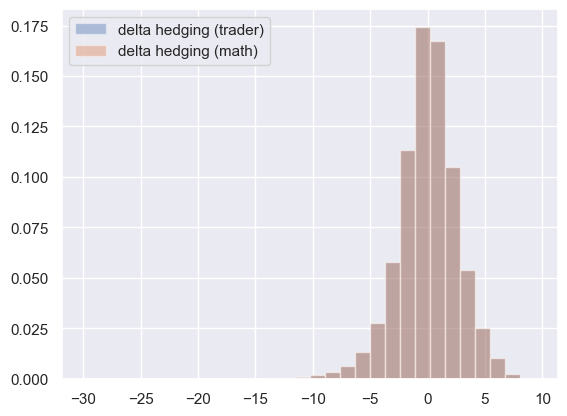

In [56]:
fig, ax = plt.subplots()
ax.hist(pnl_bs_trader, bins=30, density=True, alpha=0.4, label="delta hedging (trader)")
ax.hist(pnl_bs_math, bins=30, density=True, alpha=0.4, label="delta hedging (math)")
ax.legend()
plt.show()

In [57]:
pnl_bs = pnl_bs_math
pnl = pnl_math

## Fonction d'apprentissage: approche `données`

In [58]:
from tqdm import trange, tqdm

In [59]:
def learning_from_data(xj_path, zj, phi, n_epochs, batch_size, learning_rate=1e-3): 
    data_size = zj.shape[0]
    n_upd = data_size // batch_size 

    optimizer = torch.optim.Adam(phi.parameters(), lr=learning_rate)
    losses = []
    with tqdm(range(n_epochs)) as nrange:
        for n in nrange:
            indexes = torch.randperm(data_size)   # on pourrait resimuler...
            for k in range(n_upd):
                idx = indexes[k*batch_size:(k+1)*batch_size] 
                loss = (pnl(xj_path[[idx]], zj[[idx]], phi)**2).mean() #(yj[idx] - phi(xj[idx]))**2).mean()  # cf torch.MSEloss avec reduction = 'mean' 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()  # theta_{k+1} = theta_k - ...
                losses.append(loss.item())
            nrange.set_postfix(loss=loss.item())
    return losses

## Première approche: à chaque date un FNN 

In [60]:
class hedge1(nn.Module):
    def __init__(self, N, input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_q0 = nn.Parameter(torch.ones(1))
        self.hedge_q = nn.ModuleList([
            NeuralNetwork(input_size, layer_sizes, output_size) for n in range(1,N) 
        ])
    def forward(self, n, x):
        if n == 0: 
            return self.price_p0, self.hedge_q0
        else:
            return self.hedge_q[n-1](x)

In [61]:
phi1 = hedge1(N, 1, [16, 16], 1)
n_epochs = 32
batch_size = 2**12
loss1 = learning_from_data(xj_path, zj, phi1, n_epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:41<00:00,  1.30s/it, loss=0.000173]


In [62]:
phi1.state_dict()

OrderedDict([('price_p0', tensor([0.0749])),
             ('hedge_q0', tensor([0.7028])),
             ('hedge_q.0.linear_relu_stack.0.weight',
              tensor([[ 0.1523],
                      [ 0.4301],
                      [-0.1050],
                      [-0.6902],
                      [-0.2137],
                      [ 0.6311],
                      [-0.5213],
                      [-0.8364],
                      [ 0.1009],
                      [ 0.8738],
                      [ 0.9320],
                      [ 1.3460],
                      [-0.8783],
                      [ 0.0316],
                      [-0.2645],
                      [-0.5592]])),
             ('hedge_q.0.linear_relu_stack.0.bias',
              tensor([-0.9198, -0.2216,  0.3001,  1.0394, -0.6261, -0.1507, -0.7993, -0.0583,
                      -0.1930, -0.7252,  1.0299, -0.5268, -0.1944,  0.4623, -0.6901,  0.1685])),
             ('hedge_q.0.linear_relu_stack.2.weight',
              tensor([[-7.86

In [63]:
# pour aligner les histogrammes on récupère les bins
_, bins = np.histogram(pnl_bs, bins=30)

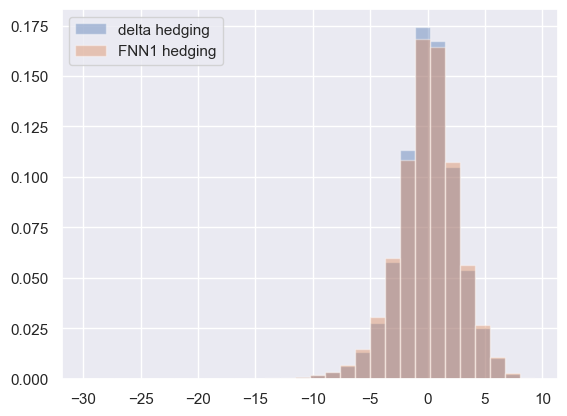

In [64]:
pnl_FNN1 = L*pnl(xj_path, zj, phi1).detach().numpy().flatten()
fig, ax = plt.subplots()
ax.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_FNN1, bins=bins, density=True, alpha=0.4, label="FNN1 hedging")
ax.legend()
plt.show()

In [65]:
pnl_bs.var()

6.6341724

In [66]:
pnl_FNN1.var()

6.997198

## Seconde approche: un FNN qui dépend du temps 

In [69]:
class hedge2(nn.Module):
    def __init__(self, N, input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_q0 = nn.Parameter(torch.ones(1))
        self.hedge_q = NeuralNetwork(input_size+1, layer_sizes, output_size)
    def forward(self, n, x):
        if n == 0: 
            return self.price_p0, self.hedge_q0
        else:
            x_and_time = torch.cat([x, torch.full((x.shape[0],1), n*(T/N))], dim=1)
            return self.hedge_q(x_and_time)

In [70]:
phi2 = hedge2(N, 1, [32, 32, 32], 1)
# on peut tester plusieurs architectures: 
#phi2 = hedge2(N, 1, [16, 16, 16], 1)
#phi2 = hedge2(N, 1, [64, 16, 8], 1)
#phi2 = hedge2(N, 1, [8, 8, 8, 8], 1)
# on garde les mêmes valeurs que dans la pemière approche
# n_epochs = 32
# batch_size = 2**12
loss2 = learning_from_data(xj_path, zj, phi2, n_epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:05<00:00,  2.05s/it, loss=0.000159]


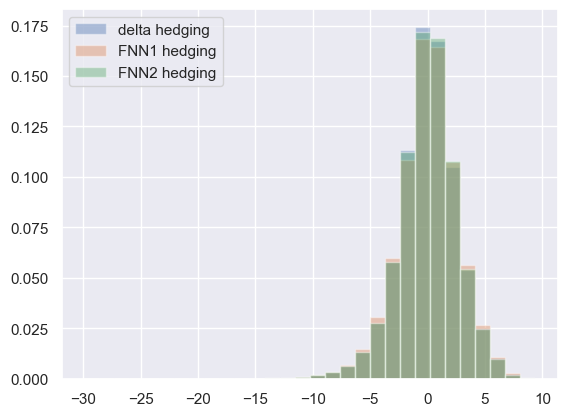

In [71]:
pnl_FNN2 = L*pnl(xj_path, zj, phi2).detach().numpy().flatten()
fig, ax = plt.subplots()
ax.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_FNN1, bins=bins, density=True, alpha=0.4, label="FNN1 hedging")
ax.hist(pnl_FNN2, bins=bins, density=True, alpha=0.4, label="FNN2 hedging")
ax.legend()
plt.show()

In [72]:
pnl_FNN2.var()

6.644237

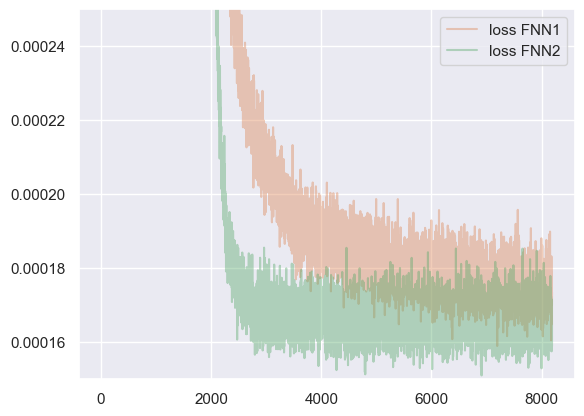

In [73]:
fig, ax = plt.subplots()
ax.plot(loss1, color='C1', alpha=0.4, label="loss FNN1")
ax.plot(loss2, color='C2', alpha=0.4, label="loss FNN2")
ax.set_ylim(0.00015, 0.00025)
ax.legend()
plt.show()

## Fonction d'apprentissage: approche `simulation`

In [74]:
n_grad_upd = n_epochs * data_size // batch_size
n_grad_upd

8192

In [75]:
def simu_data(batch_size, device=device):
    h = T/N
    brown_acc = np.sqrt(h)*torch.randn(size=(N, batch_size), device=device)
    sample_act = torch.zeros(size=(N+1, batch_size))
    sample_act[0] = x0
    for n in range(1, N+1):
        sample_act[n] = sample_act[n-1] * torch.exp((- 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    xj_path = (sample_act / L).T
    
    zj = (np.exp(-r*T) * torch.relu(np.exp(r*T) * sample_act[N] - K) / L)[:,None]
    return xj_path, zj

In [76]:
def learning_from_simu(phi, n_grad_upd, batch_size, learning_rate=1e-3): 
    optimizer = torch.optim.Adam(phi.parameters(), lr=learning_rate)
    losses = []
    with tqdm(range(n_grad_upd)) as nrange:
        for n in nrange:
            xj_path, zj = simu_data(batch_size)
            loss = (pnl(xj_path, zj, phi)**2).mean() #(yj[idx] - phi(xj[idx]))**2).mean()  # cf torch.MSEloss avec reduction = 'mean' 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  # theta_{k+1} = theta_k - ...
            losses.append(loss.item())
            nrange.set_postfix(loss=loss.item())
    return losses

In [77]:
phi1s = hedge1(N, 1, [16, 16], 1)
n_epochs = 32
batch_size = 2**12
n_grad_upd = n_epochs * data_size // batch_size
loss1s = learning_from_simu(phi1s, n_grad_upd, batch_size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:52<00:00, 155.31it/s, loss=0.000168]


In [78]:
phi2s = hedge2(N, 1, [16, 16, 16], 1)
# on garde les mêmes valeurs que dans la pemière approche
# n_epochs = 32
# batch_size = 2**12
loss2s = learning_from_simu(phi2s, n_grad_upd, batch_size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [01:05<00:00, 125.52it/s, loss=0.000164]


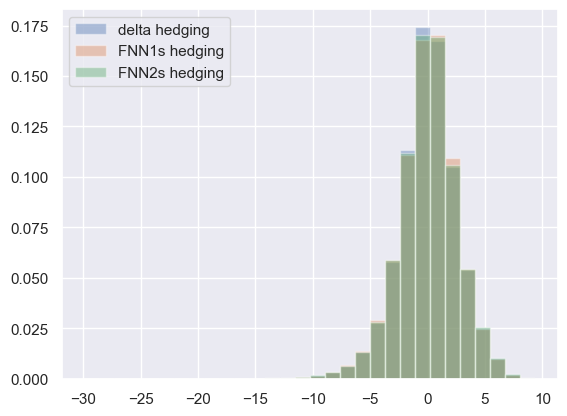

In [79]:
pnl_FNN1s = L*pnl(xj_path, zj, phi1s).detach().numpy().flatten()
pnl_FNN2s = L*pnl(xj_path, zj, phi2s).detach().numpy().flatten()
fig, ax = plt.subplots()
ax.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_FNN1s, bins=bins, density=True, alpha=0.4, label="FNN1s hedging")
ax.hist(pnl_FNN2s, bins=bins, density=True, alpha=0.4, label="FNN2s hedging")
ax.legend()
plt.show()

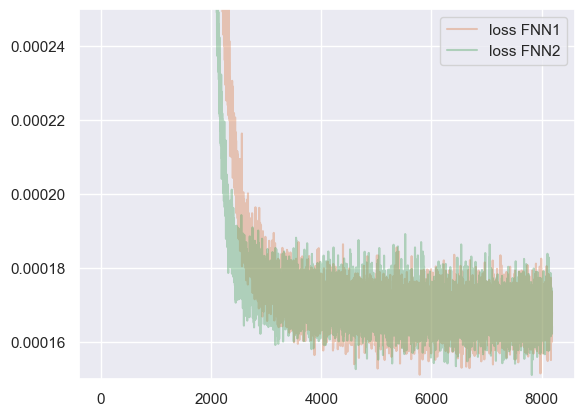

In [80]:
fig, ax = plt.subplots()
ax.plot(loss1s, color='C1', alpha=0.4, label="loss FNN1")
ax.plot(loss2s, color='C2', alpha=0.4, label="loss FNN2")
ax.set_ylim(0.00015, 0.00025)
ax.legend()
plt.show()

## Test sur de nouvelles données

In [81]:
test_size = 2**12
xj_test, zj_test = simu_data(test_size)

with torch.no_grad():
    pnl_bs = L*pnl(xj_test, zj_test, bs_hedge).detach().numpy().flatten()
    pnl_FNN1 = L*pnl(xj_test, zj_test, phi1).detach().numpy().flatten()
    pnl_FNN2 = L*pnl(xj_test, zj_test, phi2).detach().numpy().flatten()
    pnl_FNN1s = L*pnl(xj_test, zj_test, phi1s).detach().numpy().flatten()
    pnl_FNN2s = L*pnl(xj_test, zj_test, phi2s).detach().numpy().flatten()

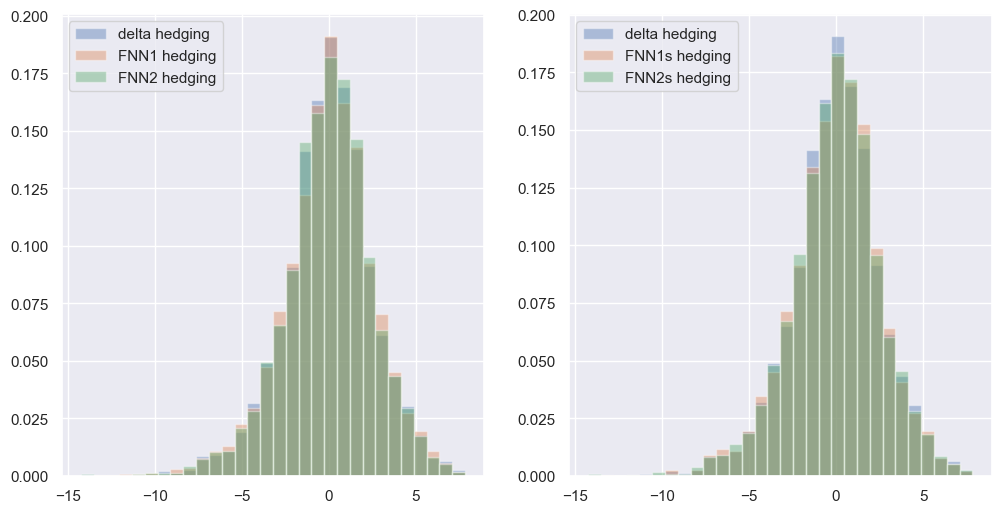

In [82]:
# pour aligner les histogrammes on récupère les bins
_, bins = np.histogram(pnl_bs, bins=30)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax1.hist(pnl_FNN1, bins=bins, density=True, alpha=0.4, label="FNN1 hedging")
ax1.hist(pnl_FNN2, bins=bins, density=True, alpha=0.4, label="FNN2 hedging")
ax1.legend()

ax2.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax2.hist(pnl_FNN1s, bins=bins, density=True, alpha=0.4, label="FNN1s hedging")
ax2.hist(pnl_FNN2s, bins=bins, density=True, alpha=0.4, label="FNN2s hedging")
ax2.legend()
plt.show()

In [83]:
monte_carlo(pnl_FNN1)

{'mean': -0.029614963,
 'var': 6.8951445,
 'lower': -0.11003046916676792,
 'upper': 0.05080054389191899}

In [86]:
monte_carlo(pnl_FNN2)

{'mean': -0.040021196,
 'var': 6.4772983,
 'lower': -0.1179620329045899,
 'upper': 0.037919640889132744}

In [85]:
monte_carlo(pnl_FNN1s)

{'mean': -0.036871806,
 'var': 6.512871,
 'lower': -0.11502637040994806,
 'upper': 0.04128275883577509}

In [87]:
monte_carlo(pnl_FNN2s)

{'mean': -0.028701702,
 'var': 6.5230145,
 'lower': -0.10691710570670403,
 'upper': 0.04951370144106186}

## Observation des fonctions de hedge obtenues

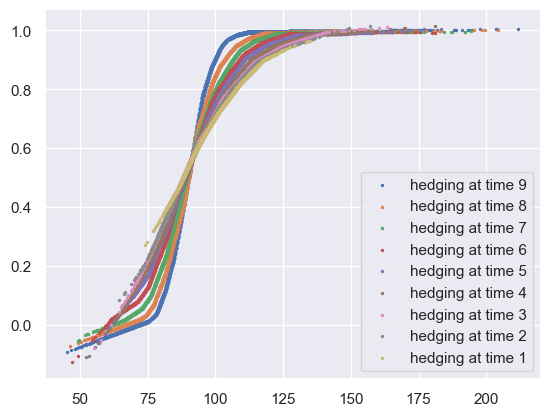

In [90]:
xx = np.linspace(20, 180, 1000)

fig, ax = plt.subplots()
for n in reversed(range(1, N)):
    with torch.no_grad():
        xx = xj_test[:, [n]].numpy()*L
        yy = phi2(n, xj_test[:,[n]]).numpy()
    ax.scatter(xx, yy, s=2, label=f"hedging at time {n}")
ax.legend()
plt.show()

## Pour aller plus loin...

- ajouter des coûts de transactions 
- modifier la loss: remplacer le mean-quadratic hedging par une autre mesure de risque à minimiser 
- passer en dimension $d \ge 2$
- changer de modèle: Heston, etc.